### Processing of raw Hi-C and RNA-seq data from source.

In [1]:
import hicstraw
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import re
import itertools
import pickle
from sklearn.manifold import TSNE

from pathlib import Path  

/nfs/turbo/dcmb-class/bioinf593/groups/group_08/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Helper functions to load HiC data (from other notebook)

def read_hic_efficiently(mzd, binned_size, resolution, max_matrix_size=2000, verbose=True):
    '''
    Helper function (do not call!)
    Reads a Hi-C with even size blocks of size (`max_matrix_size` - 1) to avoid
    crashes due to limited RAM; if too small then performance takes a hit
    * max_matrix_size = 2000 is roughly appropriate for a system with 32GB RAM 
    
    binned_size : the binned size of the whole region you'd like to access (usually found by 
    hic.getChromosomes) if extracting entire chromosome
    '''
    H = np.zeros((binned_size, binned_size))
    
    m = np.ceil(binned_size / max_matrix_size).astype(int) # length of final matrix

    for i in range(m):
        # upper triangular elements only
        for j in range(i, m):

            # read in the data
            i0 = max_matrix_size * i 
            i1 = max_matrix_size * (i + 1) - 1

            i2 = max_matrix_size * j
            i3 = max_matrix_size * (j + 1) - 1

            if i1 >= binned_size:
                i1 = binned_size - 1

            if i3 >= binned_size:
                i3 = binned_size - 1

            p0 = i0 * resolution
            p1 = i1 * resolution 
            p2 = i2 * resolution
            p3 = i3 * resolution

            if verbose:
                print("Entry: ({}, {}) of ({}, {})".format(i, j, m - 1, m - 1))

            H[i0:i1+1, i2:i3+1] = mzd.getRecordsAsMatrix(p0, p1, p2, p3)
            H[i2:i3+1, i0:i1+1] = mzd.getRecordsAsMatrix(p0, p1, p2, p3).T
            
    return H


def read_hic_file(filename, chrom, resolution, positions, data_type, normalization="NONE", max_matrix_size=False, verbose=True):
    '''
    filename (str) : path to .hic file
    chrom (str) : specify chromosome (e.g., "chr3") – also printed if verbose=True
    positions (int, int) : tuple of start and end 1-indexed basepair resolution, or "all"
    data_type (str) = ["observed", "oe"] : according to hicstraw documentation 
    normalization (str) = ["NONE", "VC", "VC_SQRT", "KR", "SCALE"]: according to hicstraw documentation 
    max_matrix_size (int or False)
        Default is False (normal)
        Otherwise, this reads a Hi-C in chunks of size (`max_matrix_size` - 1) to avoid crashes due to limited RAM 
        (note: if max_matrix_size is too small then performance takes a hit)
        
        max_matrix_size = 2000 is roughly appropriate for a system with 32GB RAM 
    '''
    hic = hicstraw.HiCFile(filename)
    if verbose:
        print("Identified")
        print("Possible resolutions")
        for possible_res in hic.getResolutions():
            print(" * {}".format(possible_res))
        print("Chrom name : Chrom size:")
    found = False
    start_pos = 0
    end_pos = -1
    for chromosome in hic.getChromosomes():
        if verbose:
            print("  -", chromosome.name, chromosome.length, end="")
        
        if str(chrom) == chromosome.name:
            key = chromosome.name
            found = True
            end_pos = chromosome.length
            if verbose:
                print(" <- Selected", end="")
                
        if verbose:
            print()
        
    if not found:
        print("Chromosome '{}' could not be identified. Check again.".format(chrom))
        return
    
    mzd = hic.getMatrixZoomData(key, key, data_type, normalization, "BP", int(resolution))
    
    if positions != "all":
        start_pos = positions[0]
        end_pos = positions[1]
        
    if max_matrix_size:
        binned_size = np.ceil((end_pos - start_pos) / resolution).astype(int)
        return read_hic_efficiently(mzd, binned_size, resolution, max_matrix_size, verbose)
        
    return mzd.getRecordsAsMatrix(start_pos, end_pos, start_pos, end_pos)

In [3]:
def plot_hic(A, title, savepath, log=True):
    print("Plotting Hi-C...")
    plt.close("all")
    
    plt.figure(figsize=(5, 6), layout="constrained")
    
    if log:
        plt.imshow(np.log10(A + 1), cmap="Reds")
    else:
        plt.imshow(A, cmap="Reds")
        
    def_xticks = plt.gca().get_xticks()[1:]
    def_yticks = plt.gca().get_yticks()[1:]
    
    # Add lower bound to both x and y because matrix is naturally 0-indexed
    ticks_bp_x = [genomic_labels(x) for x in list(def_xticks * resolution)]
    ticks_bp_y = [genomic_labels(x) for x in list(def_yticks * resolution)]
    
    plt.xticks(ticks=def_xticks, labels=ticks_bp_x, fontsize=8, rotation=30)
    plt.yticks(ticks=def_yticks, labels=ticks_bp_y, fontsize=8)

    plt.title(title, fontsize=10)
    
    plt.savefig(savepath, dpi=400)
    
    plt.close("all")

In [4]:
def load_hic(hic_path, resolution, chromosome, data_type, plot=False):
    """Load HiC data from a given directory.

    Args:
        hic_path: path to directory containing .hic data files
        resolution: Mbp resolution to load the data in

    Returns:
        List of (filename, tensor) tuples
    """
    data = []
    files = list(Path(hic_path).iterdir())
    
    if plot:
        forplot = read_hic_file(filename=str(files[0]),
                chrom=chromosome, 
                resolution=int(resolution), 
                positions="all", # All positions of chromosome 3
                data_type=data_type, 
                normalization="KR", # KR matrix balancing – Good default parameter (just makes this matrix have equal row and column sums)
                max_matrix_size=False, 
                verbose=False
            )
        A_agg = np.zeros_like(forplot)
        count = 0
    
    
    for i, filename in enumerate(files):
        if i % 50 == 0:
            percent = i / len(files) * 100
            print(f"Loaded {i} files out of {len(files)} [{percent:.2f}%]")

        filename = str(filename)
        A = read_hic_file(filename=filename,
                chrom=chromosome, 
                resolution=int(resolution), 
                positions="all", # All positions of chromosome 3
                data_type=data_type, 
                normalization="KR", # KR matrix balancing – Good default parameter (just makes this matrix have equal row and column sums)
                max_matrix_size=False, 
                verbose=False
            )
        if plot:
            A_agg += A
            count += 1
        
        data.append((filename, torch.tensor(A)))
        
    
    if plot:
        A_agg /= count # normalize so we get average signal
        logs = [True, False]
        for log in logs:
            plot_hic(A_agg, 
                     "Aggregate of {} (time={})\n{} {} Observed".format(CELLLINE, TIME, genomic_labels(RESOLUTION), chromosome),
                     SAVE_PATH + "{}_plot_{}_{}_{}_time-{}_log_{}.png".format(CELLLINE, genomic_labels(RESOLUTION), CHROMOSOME, DATA_TYPE, TIME, log), log=log)

    return data

In [5]:
def load_rnaseq_dataframe(filename):
    """Load the RNASeq file as a dataframe."""
    rna = pd.read_csv(filename, compression="infer", delimiter="\t")
    return rna

In [6]:
def load_genebank(filename):
    return pd.read_csv(filename, sep="\t")

In [8]:
def genomic_labels(pos):
    if np.abs(pos) >= 1e6:
        return "{0:g}".format(pos / 1e6).rstrip(".") + "Mb"
    elif np.abs(pos) >= 1e3:
        return "{0:g}".format(pos / 1e3).rstrip(".") + "Kb"
    else:
        print("bp resolution")
        return "{}bp".format(pos)

In [9]:
def rnaseq_process(rnaseq, mart, chromosome, time):
    # Subset only those that exist
    rnaseq = rnaseq.loc[rnaseq["gene"].isin(mart["Gene name"]) | rnaseq["gene"].isin(mart["MGI symbol"]) | rnaseq["gene"].isin(mart["Gene Synonym"])].reset_index(drop=True)
    
    # Generate gene to data keys
    attributes = ['Gene start (bp)', 'Gene end (bp)', 'Chromosome/scaffold name']
    gene_key_1 = dict(zip(mart["Gene name"].values, mart[["Gene name"] + attributes].values.tolist()))
    gene_key_2 = dict(zip(mart["MGI symbol"].values, mart[["MGI symbol"] + attributes].values.tolist()))
    gene_key_3 = dict(zip(mart["Gene Synonym"].values, mart[["Gene Synonym"] + attributes].values.tolist()))

    gene_key = gene_key_1 | gene_key_2 | gene_key_3

    # Append data
    gene_pos = pd.DataFrame(list(rnaseq["gene"].apply(lambda x : gene_key[x])), columns=["gene"] + attributes)
    rnaseq = pd.merge(rnaseq, gene_pos, on="gene")
    
    # Subset chromosome
    chromosome_num = int(re.sub("[^0-9]", "", chromosome))
    return rnaseq.loc[rnaseq["Chromosome/scaffold name"] == str(chromosome_num)].reset_index(drop=True)

In [10]:
def rnaseq_time(rnaseq, meta_file, time):
    
    print("Processing RNAseq data...")
    # Load metadata for time sub-setting
    meta = pd.read_excel(meta_file, engine="openpyxl")
    meta_cols = meta["Cellname"]

    if type(time) == list:
        for t in time:
            if t not in time_dict.keys():
                print("time='{}' not recognized\ntime=['all', 7, 7.5, 8, 8.5, 9, 9.5, 10.5, 11.5]".format(t))
                assert False

        # Convert time (float) into strings to match with metadata file 
        time_conv = [time_dict[x] for x in time]

        # Subset
        meta_cols = meta.loc[meta["Stage"].isin(time_conv), "Cellname"].reset_index(drop=True)

    elif time != "all":
        if time not in time_dict.keys():
            print("time='{}' not recognized\ntime=['all', 7, 7.5, 8, 8.5, 9, 9.5, 10.5, 11.5]".format(time))

        # time is the right key
        meta_cols = meta.loc[meta["Stage"] == time_dict[time], "Cellname"].reset_index(drop=True)


    print("  For t={}, number of RNA-seq cells: {} -> {} ({} matched)".format(time, rnaseq.shape[1], pd.Series(rnaseq.columns).isin(meta_cols.tolist()).sum(), len(meta_cols)))

    return rnaseq[meta_cols]

In [11]:
def create_dataset(hic_path, rnaseq_file, genebank_file, meta_file, chromosome, time, data_type="observed", resolution=1e9, plot=True):
    """Load the HiC and RNASeq data and create a dataset by matching the cells from each.

    Args:
        hic_path: path to directory containing .hic data files
        rnaseq_file: file containing the rnaseq data
        resolution: Mbp resolution to load the data in. Defaults to 1e9bp (1Mbp).
        chromosome="chr6" : defaults to chromosome 6 (contains *Nanog* gene and *Hox* genes, key for development) 
            - See [paper](https://www.jbc.org/article/S0021-9258(20)65622-8/abstract))
            - Another suitable candidate is the chromosome containing *Sox* genes
        time=["all", 7, 7.5, 8, 8.5, 9, 9.5, 10.5, 11.5] : see figure below

    Returns:
        List of {hic: tensor, rnaseq: tensor} dictionaries
    """
    # MAIN DATA
    print("Loading HiC data...")
    hic = load_hic(hic_path, resolution, chromosome, data_type, plot)  # list of (filename, tensor) tuples
    print("Loading RNASeq data...")
    rnaseq = load_rnaseq_dataframe(rnaseq_file)  # dataframe where each hic filename corresponds to a column
    
    # APPEND ADDITIONAL COLUMNS (GENE START, END, CHROM) TO RNA-SEQ
    mart = load_genebank(genebank_file)
    rnaseq = rnaseq_process(rnaseq, mart, chromosome, time)
    
    # SUBSET ROWS ACCORDING TO TIME
    rnaseq = rnaseq_time(rnaseq, meta_file, time)

    data = []
    for filename, A in hic:
        cellname = filename.split("_")[-1].split(".hic")[0]  # filename in form /*/*/GSM.*_cellname.hic
        if cellname not in rnaseq:
            print(f"Error: Cell {cellname} not found in RNASeq data!")
            continue

        rna = torch.tensor(rnaseq[cellname])
        data.append({"filename": filename, "hic": A, "rnaseq": rna})

    return data

def union2(dict1, dict2):
    return dict(list(dict1.items()) + list(dict2.items()))

In [12]:
def save_dataset(data, filename):
    """Save the dataset to disk."""
    torch.save(data, filename)

## Parameters
- `chromosome`=`"chr6"` : defaults to chromosome 6 (contains *Nanog* gene and *Hox* genes, key for development; see [paper](https://www.jbc.org/article/S0021-9258(20)65622-8/abstract))
    - Another suitable candidate is the chromosome containing *Sox* genes
- `time`=`["all", 7, 7.5, 8, 8.5, 9, 9.5, 10.5, 11.5]` : see figure below

<img src="graphics/time.png" width=500>

In [13]:
# CELLLINE = "brains"
CELLLINE = "embryos"

GENEBANK_FILENAME = '/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/mart_export.txt'
CHROMOSOME = "chr6"
# TIME = "all" 
TIME = 'all'
RESOLUTION = 100e3
DATA_TYPE = "observed"

In [14]:
if CELLLINE == "brains":
    HIC_PATH = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/processed/Brains/hi_c"
    RNASEQ_FILENAME = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/rna_seq/GSE223917_HiRES_brain.rna.umicount.tsv.gz"
    META_FILENAME = '/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/rna_seq/GSE223917_HiRES_brain_metadata.xlsx'
    SAVE_PATH = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/brains/raw/"
    if TIME != "all":
        print("No time impelmented for brains. Setting `TIME` to 'all'")
        TIME = "all"
elif CELLLINE == "embryos":
    HIC_PATH = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/processed/Embryos/hi_c" # EMBRYOS
    RNASEQ_FILENAME = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/rna_seq/GSE223917_HiRES_emb.rna.umicount.tsv.gz" # EMBRYOS
    META_FILENAME = '/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/rna_seq/GSE223917_HiRES_emb_metadata.xlsx'
    SAVE_PATH = "/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/embryos/raw/"


time_dict = {
    7 : 'E70',
    7.5 : 'E75',
    8 : 'E80',
    8.5 : 'E85',
    9.5 : 'E95',
    10.5 : 'EX05',
    11.5 : 'EX15',
    "all" : "all"
}

In [58]:
data = create_dataset(HIC_PATH, RNASEQ_FILENAME, GENEBANK_FILENAME, META_FILENAME, CHROMOSOME, time_dict[TIME], DATA_TYPE, RESOLUTION, True)

Loading HiC data...
Loaded 0 files out of 426 [0.00%]
Loaded 50 files out of 426 [11.74%]
Loaded 100 files out of 426 [23.47%]
Loaded 150 files out of 426 [35.21%]
Loaded 200 files out of 426 [46.95%]
Loaded 250 files out of 426 [58.69%]
Loaded 300 files out of 426 [70.42%]
Loaded 350 files out of 426 [82.16%]
Loaded 400 files out of 426 [93.90%]
Plotting Hi-C...
bp resolution
bp resolution
Plotting Hi-C...
bp resolution
bp resolution
Loading RNASeq data...
Processing RNAseq data...
  For t=all, number of RNA-seq cells: 403 -> 399 (399 matched)
Error: Cell ValbB8w1031 not found in RNASeq data!
Error: Cell ValbB8w1059 not found in RNASeq data!
Error: Cell ValaB8w4075 not found in RNASeq data!
Error: Cell ValaB8w4119 not found in RNASeq data!
Error: Cell ValbB8w1171 not found in RNASeq data!
Error: Cell ValbB8w1073 not found in RNASeq data!
Error: Cell ValbB8w1156 not found in RNASeq data!
Error: Cell ValaB8w3015 not found in RNASeq data!
Error: Cell ValbB8w1166 not found in RNASeq data!

In [307]:
save_dataset(data, SAVE_PATH + "{}_dataset_{}_{}_{}_time-{}_.pt".format(CELLLINE, genomic_labels(RESOLUTION), CHROMOSOME, DATA_TYPE, TIME))

## T-SNE visualization

In [14]:
def tsne_combined(rnaseq, hic):
    """Creation of combined rnaseq/hic dataset.
    Inputs:
        rnaseq: pd dataframe containing rnaseq data (as returned by load_rnaseq_dataframe)
        hic: list of tuples containing (file, torch.Tensor) pairs with each cell's hic contact matrix
    """

    # collect matching, flattened hic contact matrices
    hic_data = []
    for i in range(len(hic)):
        for j in rnaseq.columns:
            if hic[i][0][-15:-4] == j: # hard-coded range but it works in lieu of regular expression usage
                hic_data.append(torch.flatten(hic[i][1]).tolist())
    # combine the two datasets
    rna_hic_data = []
    for i in range(len(hic_data)):
        d = hic_data[i] + list(rnaseq[rnaseq.columns[i]])
        rna_hic_data.append(d)
    return np.array(rna_hic_data)

In [ ]:
rna_hic_np = tsne_combined(t, hic)

In [140]:
# hic_labels = list(map(lambda x: x[0][-15:-4], hic))
hic_data = []
for i in range(len(hic)):
    for j in t.columns:
        if hic[i][0][-15:-4] == j:
            hic_data.append(torch.flatten(hic[i][1]).tolist())


In [141]:
rna_hic_data = []
for i in range(len(hic_data)):
    d = hic_data[i] + list(t[t.columns[i]])
    rna_hic_data.append(d)

In [144]:
rna_hic_np = np.array(rna_hic_data)

In [146]:
from sklearn.manifold import TSNE

In [152]:
hic_np = np.array(hic_data)

In [153]:
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')
embedding2d = tsne.fit_transform(hic_np)

/nfs/turbo/dcmb-class/bioinf593/groups/group_08/env/lib64/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [154]:
embeddingDF = pd.DataFrame()
# embeddingDF['proteins'] = proteinAnnodf['preferred_name']
embeddingDF['x'] = embedding2d[:,0] # Extracting first dimension of reduced dimensionality embedding
embeddingDF['y'] = embedding2d[:,1] # Second dimension of reduced dimensionality embedding

embeddingDF.head()

,x,y
0,44.175041,62.664280
1,-19.615290,36.919270
2,3.013051,-47.520824
3,-29.320723,6.248616
4,-35.977261,1.812616


### Get labels

In [36]:
meta = pd.read_excel(META_FILENAME, engine='openpyxl')

In [37]:
cell_type = []
for col in labels:
    cell_type.append(meta.loc[meta['Cellname'] == col]['Celltype'].values[0])


In [38]:
cell_stage = []
for col in labels:
    cell_stage.append(meta.loc[meta['Cellname'] == col]['Stage'].values[0])

In [15]:
# x = torch.load('/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/embryos/raw/embryos_dataset_100Kb_chr6_observed_time-all_.pt')
x = torch.load('/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/embryos/raw/embryos_dataset_500Kb_chr17_observed_time-all.pt') # 500kb chr17

In [17]:
with open('filename.pickle', 'rb') as handle:
    tsne_data = pickle.load(handle)

In [34]:
def unpack_dataset(x):
    """Unpack raw dataset object into list of combined hi-c + rnaseq data.
    Inputs:
        x: dataset file object located in embryos/raw directory
    """
    labels = []
    unpacked_data = []
    for d in x:
        hic_m = d['hic'].numpy()
        hic = list(hic_m[np.triu_indices(hic_m.shape[0])])
        # rnaseq = d['rnaseq'].tolist()
        label = d['filename'].split('/')[-1].split('_')[-1][:-4]
        # if len(rnaseq) != 2142 or len(hic) != 18145:
        #     continue
        if len(hic) != 18145:
            continue
        unpacked_data.append(hic)
        labels.append(label)
    
    return np.array(unpacked_data), labels

In [35]:
tsne_data, labels = unpack_dataset(x)

In [ ]:

with open('filename.pickle', 'wb') as handle:
    pickle.dump(tsne_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
trunc = 1500
tsne = TSNE(random_state = 0, n_iter = 1000, perplexity=600, metric = 'euclidean', n_jobs=2)
embedding2d = tsne.fit_transform(tsne_data[:trunc, :])

In [44]:
label_str = cell_stage # cell_stage
labels_set = set(label_str)
label_d = {}
count = 0
for i in labels_set:
    label_d[i] = count
    count += 1
labels = []
for i in label_str:
    labels.append(label_d[i])

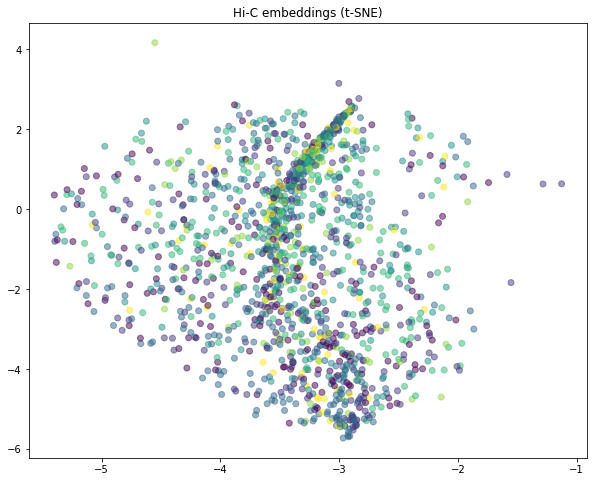

In [45]:
embeddingDF = pd.DataFrame()
# embeddingDF['proteins'] = proteinAnnodf['preferred_name']
embeddingDF['x'] = embedding2d[:,0] # Extracting first dimension of reduced dimensionality embedding
embeddingDF['y'] = embedding2d[:,1] # Second dimension of reduced dimensionality embedding

fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(embeddingDF.x, embeddingDF.y, alpha=0.5, c=labels[:trunc])

plt.title('Hi-C embeddings (t-SNE)')
# plt.ylim([-10, 10])
plt.show()

In [25]:
from sklearn.manifold import SpectralEmbedding

embed = SpectralEmbedding(n_components=2)
embedding = embed.fit_transform(tsne_data)

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)

plt.title('Hi-C embeddings (Spectral Embedding)')
plt.show()

In [15]:
import umap as um

In [16]:
reducer = um.UMAP()
embedding = reducer.fit_transform(tsne_data)
embedding.shape

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)

plt.title('Hi-C embeddings (UMAP)')
plt.show()